# Cotton Leaf Disease Classification

### 1. Imports

In [ ]:
import os
import matplotlib.pyplot as plt
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
print(os.listdir("Cotton Plant Images"))

### 2. Load Data

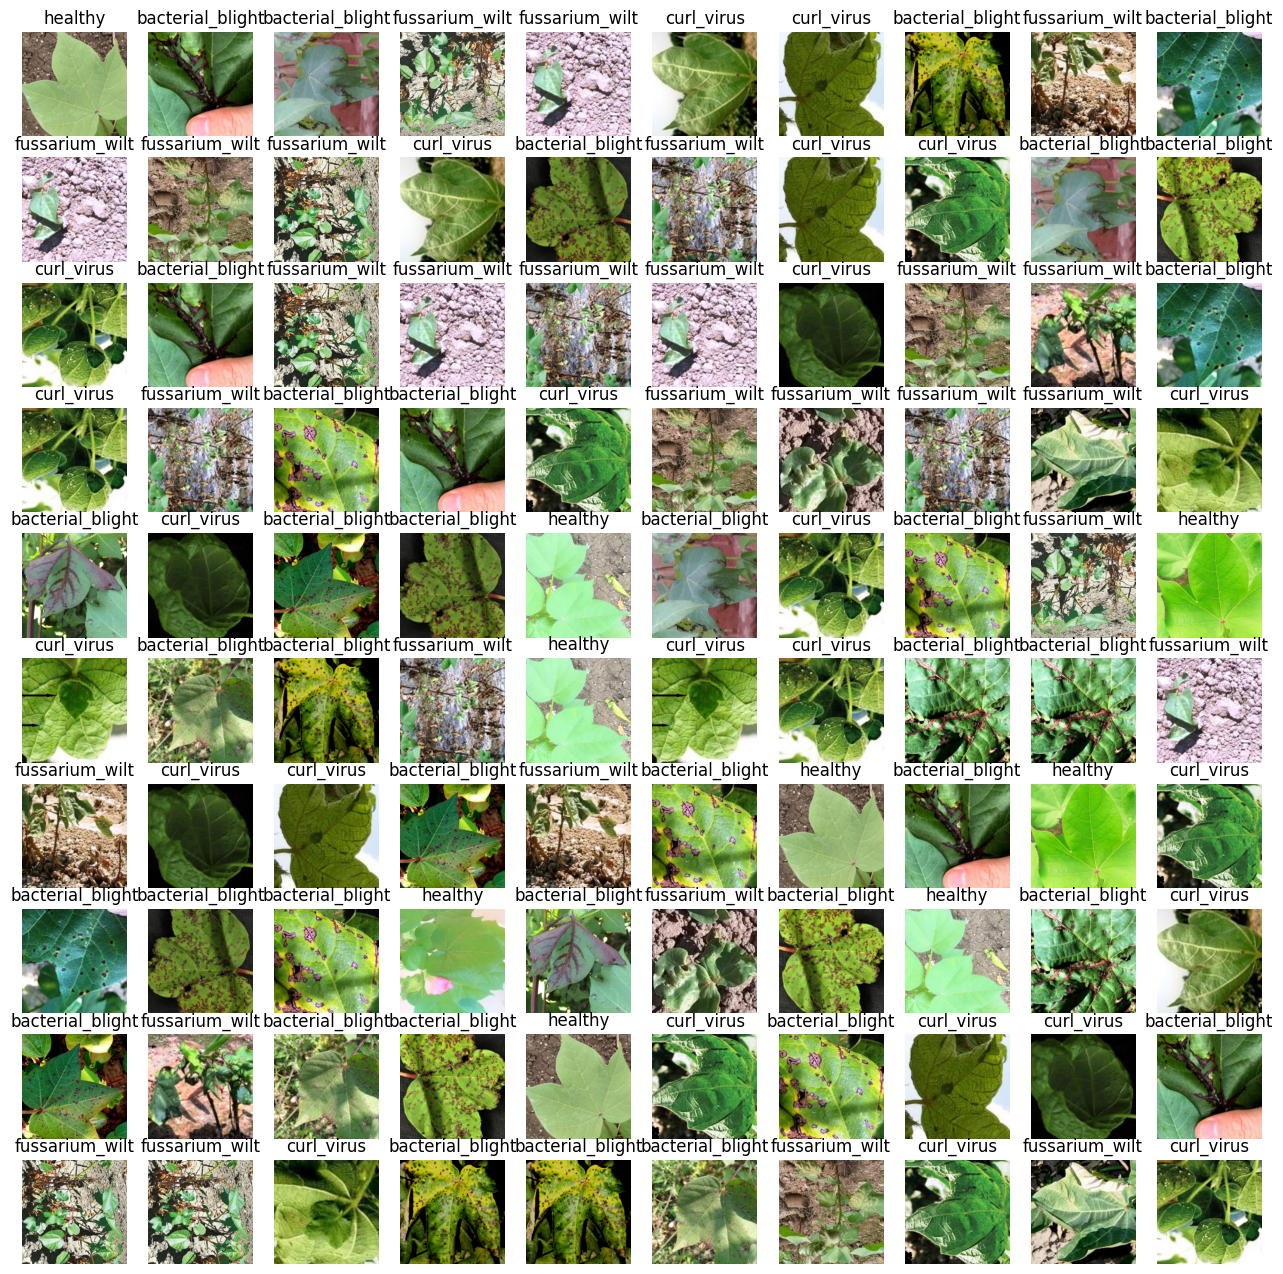

In [81]:
transform = transforms.Compose([
    transforms.Resize(384),       
    transforms.CenterCrop(350),   
    transforms.ToTensor()         
])

dataset = datasets.ImageFolder('Cotton Plant Images', transform=transform)

train_size = len(dataset) // 2
test_size = len(dataset) - train_size 
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)  # No shuffle for testing

labels_map = {
    0: "bacterial_blight",
    1: "curl_virus",
    2: "fussarium_wilt",
    3: "healthy",
}

# Get a batch of images from the training set
data_iter = iter(train_loader)
images, labels = next(data_iter)

# Display Sample Images
figure = plt.figure(figsize=(16, 16))
cols, rows = 10, 10

for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(images), size=(1,)).item()
    img, label = images[sample_idx], labels[sample_idx].item()

    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis("off")
    
    img = img.permute(1, 2, 0)  # Convert (C, H, W) to (H, W, C) for display
    plt.imshow(img)

plt.show()

### 3. Object Detection Leaf/Plant

In [ ]:
# Nats Code

